# Fair Value Estimator

### About

I wrote this notebook so that my friends and I can save time when estimating the fair value of a stock. All information about the stock is pulled from [Morningstar](https://www.morningstar.com/). Note that this is just how I estimate the fair value, and that my methods, just like all methods, are imperfect. The fair value will never be exactly equal to what I estimate it to be at, but on average I expect to be close enough. As a long-term investor, I'm confident that if I continually buy strong stocks at prices significantly below fair value, I will make alot of money in the long run.

Here are some things to keep in mind: 
* The following modules need to be installed on your computer: Ipython, numpy, pandas, matplotlib, seaborn, selenium
* This method of valuation only works for established companies with positive earnings. Investing in a new company with no history or negative earnings is speculative in nature, which makes it hard to put a "fair value" on such a stock.
* User needs to input 3 values: the ticker symbol of the stock being valued, the acceptable annual returns (%), the expected future growth (%), and the PE ratio that the stock will be sold at.
* Buying a stock when it's cheap is only one part of the equation. The stock needs to have a "moat", and ideally a good balance sheet, and you need to understand the business (so you know when to sell). If any of these need clarification, please see the link below.
* I have details behind how I estimate fair value, notes/tips on investing and how to use this notebook in the grand scheme of things in my [Github repository](https://github.com/zihanye96/Classifying-Toxic-Comments).


In [1]:
## required libraries
import IPython
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## for web scraping
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait as wait

In [2]:
ticker = "AAPL"

In [3]:
import datetime
present_year = datetime.datetime.now().year

In [4]:
rownames = list(np.arange(present_year-10,present_year+1))

In [5]:
stock_data = pd.DataFrame({"Year":rownames})

In [6]:
def fetchPriceRatios(ticker):
    
    driver = webdriver.Chrome(executable_path='./chromedriver')
    driver.get(f'http://financials.morningstar.com/valuation/price-ratio.html?t={ticker}&region=usa&culture=en-US')

    tbody = wait(driver, 10).until(EC.presence_of_element_located((By.ID, "valuation_history_table")))

    rows = tbody.find_elements_by_tag_name("tr")

    row_content = [row.text for row in rows]
    stock_data["PE Ratio"] = row_content[1].split(" ")[1:]
    stock_data["Price to Book"] = row_content[4].split(" ")[1:]
    stock_data["Price to Sales"] = row_content[7].split(" ")[1:]

    driver.close()

In [7]:
def fetchFinancials(ticker):
    
    driver = webdriver.Chrome(executable_path='./chromedriver')
    driver.get(f'http://financials.morningstar.com/ratios/r.html?t={ticker}&region=usa&culture=en-US')
    
    tbody = wait(driver, 10).until(EC.presence_of_element_located((By.ID, "financials")))
    rows = tbody.find_elements_by_tag_name("tr")
    row_content = [row.text for row in rows]
    
    currency = row_content[2].split(" ")[1]
    stock_data["Revenue"] = row_content[2].split(" ")[3:]
    stock_data["Net Income"] = row_content[10].split(" ")[4:]
    stock_data[f"EPS ({currency})"] = row_content[12].split(" ")[4:]
    stock_data["BVPS"] = row_content[20].split(" ")[6:]
    
    tbody = wait(driver, 10).until(EC.presence_of_element_located((By.ID, "tab-profitability")))
    rows = tbody.find_elements_by_tag_name("tr")
    row_content = [row.text for row in rows]
    
    stock_data["ROE"] = row_content[32].split(" ")[4:]
    stock_data["ROIC"] = row_content[34].split(" ")[5:]
    
    driver.close()

In [8]:
fetchPriceRatios(ticker)
fetchFinancials(ticker)

In [9]:
type(stock_data[["BVPS"]])

pandas.core.frame.DataFrame

In [10]:
stock_data.loc[1, "BVPS"]

'11.78'

In [11]:
type(stock_data["Revenue"][0])

str

In [12]:
def to_num(column):
    if type(column[0]) == str:
        return(column.str.replace(',', '').str.replace('—', '0').astype(float))
    else:
        return(column)

In [13]:
stock_data.apply(to_num, axis=0)

,Year,PE Ratio,Price to Book,Price to Sales,Revenue,Net Income,EPS (USD),BVPS,ROE,ROIC
0,2010,18.0,5.4,3.9,65225.0,14013.0,2.16,7.45,37.06,36.44
1,2011,14.6,4.9,3.5,108249.0,25922.0,3.95,11.78,41.67,41.04
2,2012,12.1,3.9,3.1,156508.0,41733.0,6.31,16.99,42.84,42.01
3,2013,14.1,4.1,3.1,170910.0,37037.0,5.68,19.60,30.64,26.08
4,2014,17.1,5.8,3.7,182795.0,39510.0,6.45,20.62,33.61,26.20
5,2015,11.4,4.9,2.6,233715.0,53394.0,9.22,22.53,46.25,31.32
6,2016,13.9,4.7,3.0,215639.0,45687.0,8.31,23.71,36.90,21.95
7,2017,18.4,6.4,3.9,229234.0,48351.0,9.21,25.83,36.87,19.86
8,2018,13.2,7.0,3.0,265595.0,59531.0,11.91,24.17,49.36,24.41
9,2019,24.7,14.2,5.2,260174.0,55256.0,11.89,21.71,55.92,25.75


In [14]:
stock_data = stock_data.apply(to_num, axis=0)

In [15]:
revenue_percent_change = stock_data.iloc[:, 4].pct_change()
Income_percent_change = stock_data.iloc[:, 5].pct_change()
EPS_percent_change = stock_data.iloc[:, 6].pct_change()
BVPS_percent_change = stock_data.iloc[:, 7].pct_change()
percent_change = pd.DataFrame({"Revenue": revenue_percent_change, "Income": Income_percent_change,
                              "Book Value": BVPS_percent_change, "EPS": EPS_percent_change})

### Summary

PE Ratio over last 10 years: [18.  14.6 12.1 14.1 17.1 11.4 13.9 18.4 13.2 24.7 20.4]


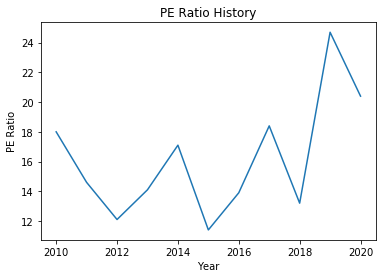

In [16]:
sns.lineplot(stock_data["Year"],stock_data["PE Ratio"])
plt.title("PE Ratio History")
print("PE Ratio over last 10 years: {}".format(np.array(stock_data["PE Ratio"])))

In [17]:
PE_sell = input("Based on historical data, what PE Ratio will you sell at?")

Based on historical data, what PE Ratio will you sell at?25


In [18]:
## format the df's better - use green for above 15%, red for negative?

print("Management Effectiveness: \n{}".format(pd.DataFrame({"ROIC": stock_data["ROIC"], 
                                                            "ROE": stock_data["ROE"]})))
print("% Growth in: \n{}".format(percent_change.iloc[1:10,:]*100))

Management Effectiveness: 
     ROIC    ROE
0   36.44  37.06
1   41.04  41.67
2   42.01  42.84
3   26.08  30.64
4   26.20  33.61
5   31.32  46.25
6   21.95  36.90
7   19.86  36.87
8   24.41  49.36
9   25.75  55.92
10  26.24  55.47
% Growth in: 
     Revenue     Income  Book Value        EPS
1  65.962438  84.985371   58.120805  82.870370
2  44.581474  60.994522   44.227504  59.746835
3   9.202086 -11.252486   15.361978  -9.984152
4   6.953952   6.677107    5.204082  13.556338
5  27.856342  35.140471    9.262852  42.945736
6  -7.734206 -14.434206    5.237461  -9.869848
7   6.304518   5.830980    8.941375  10.830325
8  15.861958  23.122583   -6.426636  29.315961
9  -2.041078  -7.181133  -10.177906  -0.167926


In [19]:
future_growth = input("Based on historical data, how much (in %) do you think the EPS will grow on average over the next 5 years?")
annual_ror = input("What is the per year rate of return (in %) do you want from this investment?")

Based on historical data, how much (in %) do you think the EPS will grow on average over the next 5 years?10
What is the per year rate of return (in %) do you want from this investment?10


In [20]:
def estimate_fair_value(EPS, future_growth, ror, PE):
    
    future_value = EPS * (1+future_growth/100)**5 * PE
    present_value = future_value/((1+ror/100)**5)
    return(future_value, present_value)

In [21]:
future, present = estimate_fair_value(stock_data.iloc[10, 6], float(future_growth), float(annual_ror), float(PE_sell))

print("Fair Value Estimate: ${:.2f}".format(present))
print("The future value of your investment is: ${:.2f}".format(future))

Fair Value Estimate: $317.50
The future value of your investment is: $511.34
